In [4]:
import pandas as pd
import os
import torchaudio
import torchaudio.transforms as T
from sklearn.model_selection import train_test_split
import numpy as np
from torchaudio.functional import edit_distance
import torch.nn as nn
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn.functional as F
import heapq
import copy
from functools import partial
from cer import calculate_cer
import werpy

In [2]:
pip install cer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install werpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 3.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Data

### Data Importing & Transcription Cleaning

Female Control

In [5]:
# Root directory
root_dir = '/kaggle/input/torgo-f-con'

# Prepare an empty list to store the data
data = []

# Loop through each speaker folder
for speaker_id in os.listdir(root_dir):
    speaker_path = os.path.join(root_dir, speaker_id)
    if os.path.isdir(speaker_path):
        session_path = os.path.join(speaker_path, 'Session1')
        
        prompts_path = os.path.join(session_path, 'prompts')
        audio_path = os.path.join(session_path, 'wav_arrayMic')
        
        if os.path.exists(prompts_path) and os.path.exists(audio_path):
            # For each transcription file
            for txt_file in os.listdir(prompts_path):
                if txt_file.endswith('.txt'):
                    base_filename = os.path.splitext(txt_file)[0]
                    
                    txt_full_path = os.path.join(prompts_path, txt_file)
                    wav_full_path = os.path.join(audio_path, f"{base_filename}.wav")
                    
                    if os.path.exists(wav_full_path):
                        # Read the actual text
                        with open(txt_full_path, 'r', encoding='utf-8') as f:
                            transcription_text = f.read().strip()  # Remove leading/trailing spaces
                        
                        # CLEANING 
                        transcription_text = transcription_text.lower().strip()  # normalize to lower-case
                        
                        # Delete if it references a jpg
                        if '.jpg' in transcription_text:
                            continue
                        # Delete if 'xxx'
                        if transcription_text == 'xxx':
                            continue
                        # Delete if empty
                        if transcription_text == '':
                            continue
                        # Delete if 'say'
                        if '[say' in transcription_text:
                            continue
                        
                        # If it contains multiple words, keep only the first word
                        first_word = transcription_text.split()[0]
                        
                        # Add to the dataset
                        data.append({
                            'Audio_path': wav_full_path,
                            'Transcription': first_word,
                            'Sex': 'F',
                            'Group': 'Control'
                        })

# Turn it into a DataFrame
fCon_df = pd.DataFrame(data)

print(fCon_df.head())
print(f"Total examples collected: {len(fCon_df)}")


                                          Audio_path Transcription Sex  \
0  /kaggle/input/torgo-f-con/FC03/Session1/wav_ar...          cart   F   
1  /kaggle/input/torgo-f-con/FC03/Session1/wav_ar...          dark   F   
2  /kaggle/input/torgo-f-con/FC03/Session1/wav_ar...           and   F   
3  /kaggle/input/torgo-f-con/FC03/Session1/wav_ar...       trouble   F   
4  /kaggle/input/torgo-f-con/FC03/Session1/wav_ar...         start   F   

     Group  
0  Control  
1  Control  
2  Control  
3  Control  
4  Control  
Total examples collected: 537


Female Dysarthria

In [6]:
# Root directory
root_dir = '/kaggle/input/torgo-f-dys'

# Prepare an empty list to store the data
data = []

# Loop through each speaker folder
for speaker_id in os.listdir(root_dir):
    speaker_path = os.path.join(root_dir, speaker_id)
    if os.path.isdir(speaker_path):
        session_path = os.path.join(speaker_path, 'Session1')
        
        prompts_path = os.path.join(session_path, 'prompts')
        audio_path = os.path.join(session_path, 'wav_arrayMic')
        
        if os.path.exists(prompts_path) and os.path.exists(audio_path):
            # For each transcription file
            for txt_file in os.listdir(prompts_path):
                if txt_file.endswith('.txt'):
                    base_filename = os.path.splitext(txt_file)[0]
                    
                    txt_full_path = os.path.join(prompts_path, txt_file)
                    wav_full_path = os.path.join(audio_path, f"{base_filename}.wav")
                    
                    if os.path.exists(wav_full_path):
                        # Read the actual text
                        with open(txt_full_path, 'r', encoding='utf-8') as f:
                            transcription_text = f.read().strip()  # Remove leading/trailing spaces
                        
                        # CLEANING 
                        transcription_text = transcription_text.lower().strip()  # normalize to lower-case
                        
                        # Delete if it references a jpg
                        if '.jpg' in transcription_text:
                            continue
                        # Delete if 'xxx'
                        if transcription_text == 'xxx':
                            continue
                        # Delete if empty
                        if transcription_text == '':
                            continue
                        # Delete if 'say'
                        if '[say' in transcription_text:
                            continue
                        
                        # If it contains multiple words, keep only the first word
                        first_word = transcription_text.split()[0]
                        
                        # Add to the dataset
                        data.append({
                            'Audio_path': wav_full_path,
                            'Transcription': first_word,
                            'Sex': 'F',
                            'Group': 'Dysarthria'
                        })

# Turn it into a DataFrame
fDys_df = pd.DataFrame(data)

print(fDys_df.head())
print(f"Total examples collected: {len(fDys_df)}")


                                          Audio_path Transcription Sex  \
0  /kaggle/input/torgo-f-dys/F04/Session1/wav_arr...          rate   F   
1  /kaggle/input/torgo-f-dys/F04/Session1/wav_arr...          glow   F   
2  /kaggle/input/torgo-f-dys/F04/Session1/wav_arr...            go   F   
3  /kaggle/input/torgo-f-dys/F04/Session1/wav_arr...          raid   F   
4  /kaggle/input/torgo-f-dys/F04/Session1/wav_arr...         trace   F   

        Group  
0  Dysarthria  
1  Dysarthria  
2  Dysarthria  
3  Dysarthria  
4  Dysarthria  
Total examples collected: 504


Male Control

In [7]:
# Root directory
root_dir = '/kaggle/input/torgo-mcons/MC(1)'

# Prepare an empty list to store the data
data = []

# Loop through each speaker folder
for speaker_id in os.listdir(root_dir):
    speaker_path = os.path.join(root_dir, speaker_id)
    if os.path.isdir(speaker_path):
        session_path = os.path.join(speaker_path, 'Session1')
        
        prompts_path = os.path.join(session_path, 'prompts')
        audio_path = os.path.join(session_path, 'wav_arrayMic')
        
        if os.path.exists(prompts_path) and os.path.exists(audio_path):
            # For each transcription file
            for txt_file in os.listdir(prompts_path):
                if txt_file.endswith('.txt'):
                    base_filename = os.path.splitext(txt_file)[0]
                    
                    txt_full_path = os.path.join(prompts_path, txt_file)
                    wav_full_path = os.path.join(audio_path, f"{base_filename}.wav")
                    
                    if os.path.exists(wav_full_path):
                        # Read the actual text
                        with open(txt_full_path, 'r', encoding='utf-8') as f:
                            transcription_text = f.read().strip()  # Remove leading/trailing spaces
                        
                        # CLEANING 
                        transcription_text = transcription_text.lower().strip()  # normalize to lower-case
                        
                        # Delete if it references a jpg
                        if '.jpg' in transcription_text:
                            continue
                        # Delete if 'xxx'
                        if transcription_text == 'xxx':
                            continue
                        # Delete if empty
                        if transcription_text == '':
                            continue
                        # Delete if 'say'
                        if '[say' in transcription_text:
                            continue
                        
                        # If it contains multiple words, keep only the first word
                        first_word = transcription_text.split()[0]
                        
                        # Add to the dataset
                        data.append({
                            'Audio_path': wav_full_path,
                            'Transcription': first_word,
                            'Sex': 'M',
                            'Group': 'Control'
                        })

# Turn it into a DataFrame
mCon_df = pd.DataFrame(data)

print(mCon_df.head())
print(f"Total examples collected: {len(mCon_df)}")


                                          Audio_path Transcription Sex  \
0  /kaggle/input/torgo-mcons/MC(1)/MC02/Session1/...         train   M   
1  /kaggle/input/torgo-mcons/MC(1)/MC02/Session1/...          carl   M   
2  /kaggle/input/torgo-mcons/MC(1)/MC02/Session1/...          raid   M   
3  /kaggle/input/torgo-mcons/MC(1)/MC02/Session1/...         swing   M   
4  /kaggle/input/torgo-mcons/MC(1)/MC02/Session1/...        double   M   

     Group  
0  Control  
1  Control  
2  Control  
3  Control  
4  Control  
Total examples collected: 1912


Male Dysarthria

In [8]:
# Root directory
root_dir = '/kaggle/input/torgo-m-dys'

# Prepare an empty list to store the data
data = []

# Loop through each speaker folder
for speaker_id in os.listdir(root_dir):
    speaker_path = os.path.join(root_dir, speaker_id)
    if os.path.isdir(speaker_path):
        session_path = os.path.join(speaker_path, 'Session1')
        
        prompts_path = os.path.join(session_path, 'prompts')
        audio_path = os.path.join(session_path, 'wav_arrayMic')
        
        if os.path.exists(prompts_path) and os.path.exists(audio_path):
            # For each transcription file
            for txt_file in os.listdir(prompts_path):
                if txt_file.endswith('.txt'):
                    base_filename = os.path.splitext(txt_file)[0]
                    
                    txt_full_path = os.path.join(prompts_path, txt_file)
                    wav_full_path = os.path.join(audio_path, f"{base_filename}.wav")
                    
                    if os.path.exists(wav_full_path):
                        # Read the actual text
                        with open(txt_full_path, 'r', encoding='utf-8') as f:
                            transcription_text = f.read().strip()  # Remove leading/trailing spaces
                        
                        # CLEANING 
                        transcription_text = transcription_text.lower().strip()  # normalize to lower-case
                        
                        # Delete if it references a jpg
                        if '.jpg' in transcription_text:
                            continue
                        # Delete if 'xxx'
                        if transcription_text == 'xxx':
                            continue
                        # Delete if empty
                        if transcription_text == '':
                            continue
                        # Delete if 'say'
                        if '[say' in transcription_text:
                            continue
                        
                        # If it contains multiple words, keep only the first word
                        first_word = transcription_text.split()[0]
                        
                        # Add to the dataset
                        data.append({
                            'Audio_path': wav_full_path,
                            'Transcription': first_word,
                            'Sex': 'M',
                            'Group': 'Dysarthria'
                        })

# Turn it into a DataFrame
mDys_df = pd.DataFrame(data)

print(mDys_df.head())
print(f"Total examples collected: {len(mDys_df)}")


                                          Audio_path Transcription Sex  \
0  /kaggle/input/torgo-m-dys/M02/Session1/wav_arr...           sip   M   
1  /kaggle/input/torgo-m-dys/M02/Session1/wav_arr...         store   M   
2  /kaggle/input/torgo-m-dys/M02/Session1/wav_arr...        bubble   M   
3  /kaggle/input/torgo-m-dys/M02/Session1/wav_arr...         train   M   
4  /kaggle/input/torgo-m-dys/M02/Session1/wav_arr...          slip   M   

        Group  
0  Dysarthria  
1  Dysarthria  
2  Dysarthria  
3  Dysarthria  
4  Dysarthria  
Total examples collected: 558


Merging Datasets

In [9]:
# Make Con/Dys same length 
fCon_df = fCon_df.sample(n=len(fDys_df), random_state=42).reset_index(drop=True)
mCon_df = mCon_df.sample(n=len(mDys_df), random_state=42).reset_index(drop=True)

print(f"Female Control: {len(fCon_df)}")
print(f"Female Dysarthria: {len(fDys_df)}")
print(f"Male Control: {len(mCon_df)}")
print(f"Male Dysarthria: {len(mDys_df)}")


Female Control: 504
Female Dysarthria: 504
Male Control: 558
Male Dysarthria: 558


In [10]:
# Merge all datasets
torgo = pd.concat([fCon_df, fDys_df, mCon_df, mDys_df], ignore_index=True)

print(torgo.head())
print(f"Total Size: {len(torgo)}")


                                          Audio_path Transcription Sex  \
0  /kaggle/input/torgo-f-con/FC01/Session1/wav_ar...           for   F   
1  /kaggle/input/torgo-f-con/FC03/Session1/wav_ar...          rain   F   
2  /kaggle/input/torgo-f-con/FC03/Session1/wav_ar...         bloat   F   
3  /kaggle/input/torgo-f-con/FC03/Session1/wav_ar...         fruit   F   
4  /kaggle/input/torgo-f-con/FC01/Session1/wav_ar...            go   F   

     Group  
0  Control  
1  Control  
2  Control  
3  Control  
4  Control  
Total Size: 2124


## Preprocessing

### Splitting

In [11]:
train_val_df, test_df = train_test_split(
    torgo, 
    test_size=0.1,
    random_state=42, 
    stratify=torgo[['Sex', 'Group']]
)

train_df, val_df = train_test_split(
    train_val_df, 
    test_size=0.1111,  
    random_state=42, 
    stratify=train_val_df[['Sex', 'Group']])

print(f"Training set: {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print(f"Test set: {len(test_df)}")

Training set: 1698
Validation set: 213
Test set: 213


### Text and Audio 

Audio Feature Extraction

In [12]:
feature_extractor = T.MelSpectrogram(
    sample_rate=16000,
    n_fft=400,
    win_length=400,
    hop_length=160,
    n_mels=80
)

def extract_features(waveform):
    # Ensure waveform is (channel, time)
    if waveform.dim() == 1:
        waveform = waveform.unsqueeze(0)

    # Pad if too short
    if waveform.size(1) < 400:  # <- fix: size(1) not size(0)!
        pad_amount = 400 - waveform.size(1)
        waveform = torch.nn.functional.pad(waveform, (0, pad_amount))

    with torch.no_grad():
        features = feature_extractor(waveform)  # (channel, n_mels, time)
        features = features.squeeze(0)           # remove channel dimension if needed
        features = features.transpose(0, 1)     # (time, n_mels)
    return features


Vocab + Tokenize

In [13]:
# Build vocab 
all_text = " ".join(torgo['Transcription'].tolist())
vocab = ['<blank>', '<unk>'] + sorted(set(all_text))
vocab_dict = {c: i for i, c in enumerate(vocab)}
vocab_size = len(vocab)

# Tokenizer
def tokenize(text):
    return [vocab_dict.get(c, vocab_dict['<unk>']) for c in text]

Batching for DataLoader

In [14]:
def collate_fn(batch):
    features, targets = zip(*batch)  # Only unpack features and targets (no lengths)

    # Pad the feature sequences
    features = pad_sequence(features, batch_first=True, padding_value=0)  # Padding value for features (if applicable)
    
    # Pad the target sequences
    targets = pad_sequence(targets, batch_first=True, padding_value=vocab_dict['<blank>'])

    # If you need feature and target lengths, calculate them
    feature_lengths = torch.tensor([len(f) for f in features])  # Calculate length of each feature sequence
    target_lengths = torch.tensor([len(t) for t in targets])  # Calculate length of each target sequence

    return features, feature_lengths, targets, target_lengths

In [15]:
class TorgoDataset(Dataset):
    def __init__(self, dataframe, vocab_dict, feature_extractor):
        self.dataframe = dataframe
        self.vocab_dict = vocab_dict
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        waveform, sample_rate = torchaudio.load(row['Audio_path'])
        waveform = waveform.squeeze(0)

        transcription = row['Transcription']
        
        # Feature extraction
        features = self.feature_extractor(waveform)
        features = features.transpose(0, 1)  # (time, n_mels)

        # Tokenization
        target = torch.tensor([self.vocab_dict.get(c, self.vocab_dict['<unk>']) for c in transcription])

        return features, target


In [16]:
# Create datasets
train_dataset = TorgoDataset(train_df, vocab_dict, feature_extractor)
val_dataset = TorgoDataset(val_df, vocab_dict, feature_extractor)
test_dataset = TorgoDataset(test_df, vocab_dict, feature_extractor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

### APIs

In [17]:
def decode_sequence(sequence, vocab_dict):
    idx_to_token = {idx: token for token, idx in vocab_dict.items()}
    decoded = []
    previous = None
    for idx in sequence:
        idx = idx.item() if isinstance(idx, torch.Tensor) else idx
        token = idx_to_token.get(idx, '<unk>')
        if token == '<blank>':
            continue
        if token != previous:
            decoded.append(token)
            previous = token
    return "".join(decoded)

In [98]:
def compute_wer_cer(predictions, prediction_lengths, targets, target_lengths, vocab_dict):

    idx_to_token = {idx: token for token, idx in vocab_dict.items()}
    batch_size = predictions.size(0)

    total_wer = 0
    total_cer = 0

    for i in range(batch_size):
        pred = predictions[i][:prediction_lengths[i]]
        target = targets[i][:target_lengths[i]]

        pred_str = "".join([idx_to_token.get(idx.item(), "") for idx in pred])
        target_str = "".join([idx_to_token.get(idx.item(), "") for idx in target])

        # WER uses space-separated words, CER is char-by-char
        pred_words = pred_str.strip().split()
        target_words = target_str.strip().split()

        wer = edit_distance(pred_words, target_words)
        cer = edit_distance(list(pred_str), list(target_str))

        total_wer += wer
        total_cer += cer

    avg_wer = total_wer / batch_size
    avg_cer = total_cer / batch_size

    return avg_wer, avg_cer


In [62]:
def decode_sequence(sequence, vocab_dict):
    # Map from index to character
    idx_to_token = {idx: token for token, idx in vocab_dict.items()}
    
    # Remove blanks and repeated tokens (CTC decoding)
    decoded = []
    previous = None
    for idx in sequence:
        idx = idx.item() if isinstance(idx, torch.Tensor) else idx
        token = idx_to_token.get(idx, '<unk>')
        if token == '<blank>':
            continue
        if token != previous:
            decoded.append(token)
            previous = token
    return "".join(decoded)  # No spaces for character-based decoding

def compute_wer(predictions, targets, vocab_dict):
    wer = 0
    total = len(predictions)

    for pred, target in zip(predictions, targets):
        pred_text = decode_sequence(pred, vocab_dict)
        target_text = decode_sequence(target, vocab_dict)

        pred_words = pred_text.split()
        target_words = target_text.split()

        wer += edit_distance(pred_words, target_words)

    wer_score = wer / total
    return wer_score

def compute_cer(predictions, targets, vocab_dict):
    cer = 0
    total = len(predictions)

    for pred, target in zip(predictions, targets):
        pred_text = decode_sequence(pred, vocab_dict)
        target_text = decode_sequence(target, vocab_dict)

        pred_chars = list(pred_text)
        target_chars = list(target_text)

        cer += edit_distance(pred_chars, target_chars)

    cer_score = cer / total
    return cer_score


In [88]:
# NOT USING
def compute_wer(predictions, targets, vocab_dict):
    # Decode predictions and targets from indices to text
    pred_texts = [decode_sequence(pred, vocab_dict) for pred in predictions]
    target_texts = [decode_sequence(target, vocab_dict) for target in targets]
    
    # Compute WER (using torchaudio's edit_distance function)
    wer = 0
    total = len(pred_texts)
    for pred, target in zip(pred_texts, target_texts):
        wer += edit_distance(pred.split(), target.split())  # Calculate WER using edit_distance
    
    wer_score = wer / total  # WER as percentage
    return wer_score

def decode_sequence(sequence, vocab_dict):
    # Decode the sequence of indices into text using vocab_dict
    idx_to_token = {idx: token for token, idx in vocab_dict.items()}
    decoded_sequence = [idx_to_token.get(idx.item(), "<unk>") for idx in sequence]
    return " ".join(decoded_sequence)

In [18]:
def decode_batch(batch_tensor, vocab_dict):
    inv_vocab = {v: k for k, v in vocab_dict.items()}
    decoded = []
    for sequence in batch_tensor:
        tokens = [inv_vocab.get(token.item(), "") for token in sequence if token.item() in inv_vocab]
        text = " ".join(tokens).replace("<pad>", "").strip()
        decoded.append(text)
    return decoded


In [19]:
def plot_wer(train_wer, val_wer):
    plt.figure(figsize=(10, 6))
    plt.plot(train_wer, label="Train WER")
    plt.plot(val_wer, label="Validation WER")
    plt.xlabel('Epochs')
    plt.ylabel('WER')
    plt.title('WER Curves (Train vs Validation)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [20]:
def plot_cer(train_cer, val_cer):
    plt.figure(figsize=(10, 6))
    plt.plot(train_Cer, label="Train CER")
    plt.plot(val_Cer, label="Validation CER")
    plt.xlabel('Epochs')
    plt.ylabel('CER')
    plt.title('CER Curves (Train vs Validation)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [21]:
# Plotting Loss
def plot_loss(train_loss, val_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves (Train vs Validation)')
    plt.legend()
    plt.grid(True)
    plt.show()

## Model - Building

### Vanilla RNN-T Class from from Torchaudio

Link: https://pytorch.org/audio/stable/generated/torchaudio.models.RNNT.html#torchaudio.models.RNNT

In [22]:
class VanillaRNNT(nn.Module):
    def __init__(self, input_dim, vocab_size, encoder_dim=512, prediction_dim=512, joiner_dim=512):
        super().__init__()
        self.rnnt = torchaudio.models.RNNT(
            input_dim=input_dim,
            vocab_size=vocab_size,
            encoder_dim=encoder_dim,
            prediction_dim=prediction_dim,
            joiner_dim=joiner_dim,
        )
    
    def forward(self, x, y):
        return self.rnnt(x, y)

### RNNT with MultiSoftmax + Attention from Paper 

"A. Patil, V. Joshi, P. Agrawal, and R. Mehta, “Streaming bilingual end-to-end asr model using attention over multiple softmax,” Jan. 2023.

Link: https://arxiv.org/pdf/2401.11645

In [23]:
class LanguageAttentionBlock(nn.Module):
    def __init__(self, encoder_dim):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim=encoder_dim, num_heads=1, batch_first=True)
        self.fc = nn.Linear(encoder_dim, 2)  # Healthy vs Dysarthria

    def forward(self, enc_out):
        attn_output, _ = self.attention(enc_out, enc_out, enc_out)
        scores = self.fc(attn_output[:, -1, :])  # Use last timestep
        weights = torch.softmax(scores, dim=-1)
        return weights[:, 0].unsqueeze(-1), weights[:, 1].unsqueeze(-1)

In [24]:
class RNNTMultiSoftmaxAttn(nn.Module):
    def __init__(self, input_dim, vocab_size, encoder_dim=512, prediction_dim=512, joiner_dim=512):
        super(RNNTMultiSoftmaxAttn, self).__init__()
        self.encoder = torchaudio.models.Emformer(input_dim=input_dim, num_heads=8, ffn_dim=512, num_layers=6, segment_length=128)
        self.decoder = nn.LSTM(input_dim, prediction_dim, batch_first=True)
        self.language_attention = LanguageAttentionBlock(encoder_dim=prediction_dim)
        self.fc_out = nn.Linear(prediction_dim, vocab_size)

    def forward(self, features, feature_lengths):
        # Encoding step (Emformer)
        encoder_output, _ = self.encoder(features, feature_lengths)  # Shape: [batch_size, max_input_len, encoder_dim]
        
        # Decoder step (LSTM)
        
        decoder_output, _ = self.decoder(encoder_output)  # Shape: [batch_size, max_input_len, prediction_dim]
        
        # Apply the attention mechanism
        attention_weights = self.language_attention(decoder_output)  # Shape: [batch_size, max_output_len, attention_dim]
        
        # Fully connected output layer to predict logits (shape: [batch_size, max_output_len, vocab_size])
        output = self.fc_out(decoder_output)  # Shape: [batch_size, max_output_len, vocab_size]
        
        # Return both the output logits and the attention weights
        return output, attention_weights

    def get_attention_weights(self, features, feature_lengths):
        _, attention_weights = self.forward(features, feature_lengths)
        return attention_weights


The inference is done via a single beam search decoding over combined symbol set

In [25]:
class BeamSearch:
    def __init__(self, beam_width, vocab_size, blank_index):
        self.beam_width = beam_width  # Number of beams to keep
        self.vocab_size = vocab_size  # Vocabulary size
        self.blank_index = blank_index  # Index of the blank token

    def decode(self, logits):
        # logits: [timesteps, batch_size, vocab_size]
        batch_size = logits.size(1)
        max_timesteps = logits.size(0)
        
        # Initialize beams (each beam contains a list of tokens and score)
        beams = [[([], 0.0)] for _ in range(batch_size)]  # Format: [(tokens, score)]
        
        # Process each timestep
        for t in range(max_timesteps):
            next_beams = [[] for _ in range(batch_size)]
            
            # Process each beam for each timestep
            for b in range(batch_size):
                for tokens, score in beams[b]:
                    # Get the logits for the current timestep
                    timestep_logits = logits[t, b]  # Shape: [vocab_size]
                    
                    # Consider all tokens and compute new scores
                    top_k_probs, top_k_indices = torch.topk(F.log_softmax(timestep_logits, dim=-1), self.beam_width)
                    
                    for i in range(self.beam_width):
                        token = top_k_indices[i].item()
                        new_score = score + top_k_probs[i].item()
                        
                        # If token is the blank token, we can keep the previous sequence
                        if token == self.blank_index:
                            next_beams[b].append((tokens, new_score))
                        else:
                            next_beams[b].append((tokens + [token], new_score))
            
            # Prune to keep only the best beams
            for b in range(batch_size):
                next_beams[b] = sorted(next_beams[b], key=lambda x: x[1], reverse=True)[:self.beam_width]
            
            beams = next_beams
        
        # Final beam: choose the one with the highest score
        decoded_sequences = []
        for b in range(batch_size):
            best_sequence = max(beams[b], key=lambda x: x[1])
            decoded_sequences.append(best_sequence[0])  # Extract tokens
            
        return decoded_sequences

# Convert token indices to characters
def tokens_to_text(tokens, vocab_dict):
    return ''.join([vocab_dict[idx] for idx in tokens])

def decode_predictions(logits, beam_width=5, blank_index=0, vocab_dict=None):
    beam_search = BeamSearch(beam_width=beam_width, vocab_size=logits.size(-1), blank_index=blank_index)
    decoded_sequences = beam_search.decode(logits)
    decoded_texts = [tokens_to_text(tokens, vocab_dict) for tokens in decoded_sequences]
    
    return decoded_texts


### Training Loop

Due to memory and crashing issues, I'm training one epoch at a time and saving 

In [27]:
def train_one_epoch(model, dataloader, optimizer, criterion, device, vocab_dict, model_output_is_log_probs=False):
    model.train()
    epoch_loss = 0
    epoch_wer = 0
    epoch_cer = 0

    for batch in dataloader:
        features, feature_lengths, targets, target_lengths = batch
        features, feature_lengths = features.to(device), feature_lengths.to(device)
        targets, target_lengths = targets.to(device), target_lengths.to(device)

        optimizer.zero_grad()

        outputs = model(features, feature_lengths)
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        if not model_output_is_log_probs:
            outputs = outputs.log_softmax(dim=-1)

        outputs = outputs.permute(1, 0, 2)  # (time, batch, vocab_size)

        loss = criterion(outputs, targets, feature_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Calculate WER and CER
        decoded_outputs = torch.argmax(outputs, dim=-1).permute(1, 0)  # (batch, time)
        pred_lengths = feature_lengths
        wer, cer = compute_wer_cer(decoded_outputs, pred_lengths, targets, target_lengths, vocab_dict)        
        #decoded_outputs = torch.argmax(outputs, dim=-1)
        #pred_lengths = feature_lengths
        #wer, cer = compute_wer_cer(decoded_outputs, pred_lengths, targets, target_lengths, vocab_dict)
        epoch_wer += wer
        epoch_cer += cer

    avg_loss = epoch_loss / len(dataloader)
    avg_wer = epoch_wer / len(dataloader)
    avg_cer = epoch_cer / len(dataloader)

    return avg_loss, avg_wer, avg_cer

def validate_one_epoch(model, dataloader, optimizer, criterion, device, vocab_dict, model_output_is_log_probs=False):
    model.eval()
    epoch_loss = 0
    epoch_wer = 0
    epoch_cer = 0

    with torch.no_grad():
        for batch in dataloader:
            features, feature_lengths, targets, target_lengths = batch
            features, feature_lengths = features.to(device), feature_lengths.to(device)
            targets, target_lengths = targets.to(device), target_lengths.to(device)

            outputs = model(features, feature_lengths)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            if not model_output_is_log_probs:
                outputs = outputs.log_softmax(dim=-1)

            outputs = outputs.permute(1, 0, 2)  # (time, batch, vocab_size)

            loss = criterion(outputs, targets, feature_lengths, target_lengths)
            epoch_loss += loss.item()

            # Calculate WER and CER
            #decoded_outputs = torch.argmax(outputs, dim=-1)
            #pred_lengths = feature_lengths
            #wer, cer = compute_wer_cer(decoded_outputs, pred_lengths, targets, target_lengths, vocab_dict)
            decoded_outputs = torch.argmax(outputs, dim=-1).permute(1, 0)  # (batch, time)
            pred_lengths = feature_lengths
            wer, cer = compute_wer_cer(decoded_outputs, pred_lengths, targets, target_lengths, vocab_dict)
            epoch_wer += wer
            epoch_cer += cer

    avg_loss = epoch_loss / len(dataloader)
    avg_wer = epoch_wer / len(dataloader)
    avg_cer = epoch_cer / len(dataloader)

    return avg_loss, avg_wer, avg_cer


In [93]:
def train(model, train_loader, val_loader, optimizer, criterion, device, vocab_dict, num_epochs=20, patience=5):
    train_losses = []
    val_losses = []
    train_wers = []
    val_wers = []
    train_cers = []
    val_cers = []

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    model = model.to(device)

    for epoch in range(1, num_epochs + 1):
        train_loss, train_wer, train_cer = train_one_epoch(model, train_loader, optimizer, criterion, device, vocab_dict)
        val_loss, val_wer, val_cer = validate_one_epoch(model, val_loader, optimizer, criterion, device, vocab_dict)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_wers.append(train_wer)
        val_wers.append(val_wer)
        train_cers.append(train_cer)
        val_cers.append(val_cer)

        print(f"Epoch {epoch}: "
              f"Train Loss = {train_loss:.4f}, Train WER = {train_wer:.4f}, Train CER = {train_cer:.4f}, "
              f"Val Loss = {val_loss:.4f}, Val WER = {val_wer:.4f}, Val CER = {val_cer:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save best model
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping!")
                break

    return train_losses, val_losses, train_wers, val_wers, train_cers, val_cers

In [105]:
def evaluate(model, dataloader, criterion, device, vocab_dict, model_output_is_log_probs=False):
    model.eval()
    epoch_loss = 0
    epoch_wer = 0
    epoch_cer = 0

    with torch.no_grad():
        for batch in dataloader:
            features, feature_lengths, targets, target_lengths = batch
            features, feature_lengths = features.to(device), feature_lengths.to(device)
            targets, target_lengths = targets.to(device), target_lengths.to(device)

            outputs = model(features, feature_lengths)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            if not model_output_is_log_probs:
                outputs = outputs.log_softmax(dim=-1)

            outputs = outputs.permute(1, 0, 2)  # (time, batch, vocab_size)

            loss = criterion(outputs, targets, feature_lengths, target_lengths)
            epoch_loss += loss.item()

            # Decode and compute WER/CER
            decoded_outputs = torch.argmax(outputs, dim=-1).permute(1, 0)
            pred_lengths = feature_lengths
            wer, cer = compute_wer_cer(decoded_outputs, pred_lengths, targets, target_lengths, vocab_dict)
            epoch_wer += wer
            epoch_cer += cer

    avg_loss = epoch_loss / len(dataloader)
    avg_wer = epoch_wer / len(dataloader)
    avg_cer = epoch_cer / len(dataloader)

    return avg_loss, avg_wer, avg_cer


With packages 

In [28]:
def train_one_epoch(model, dataloader, optimizer, criterion, device, vocab_dict, model_output_is_log_probs=False):
    model.train()
    epoch_loss = 0
    all_wers = []
    epoch_cer = 0

    for batch in dataloader:
        features, feature_lengths, targets, target_lengths = batch
        features, feature_lengths = features.to(device), feature_lengths.to(device)
        targets, target_lengths = targets.to(device), target_lengths.to(device)

        optimizer.zero_grad()

        outputs = model(features, feature_lengths)
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        if not model_output_is_log_probs:
            outputs = outputs.log_softmax(dim=-1)

        outputs = outputs.permute(1, 0, 2)  # (time, batch, vocab_size)

        loss = criterion(outputs, targets, feature_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Calculate WER and CER
        decoded_outputs = torch.argmax(outputs, dim=-1).permute(1, 0)  # (batch, time)
        #pred_lengths = feature_lengths
        #wer, cer = compute_wer_cer(decoded_outputs, pred_lengths, targets, target_lengths, vocab_dict)        
        decoded_outputs_cpu = decoded_outputs.cpu()
        targets_cpu = targets.cpu()
        decoded_outputs = decode_batch(decoded_outputs_cpu, vocab_dict)
        targets = decode_batch(targets_cpu, vocab_dict)
        
        wer = werpy.wers(targets, decoded_outputs)
        cer = calculate_cer(decoded_outputs, targets)
        all_wers.extend(wer)
        epoch_cer += cer

    avg_loss = epoch_loss / len(dataloader)
    avg_wer = (sum(all_wers) / len(all_wers)) / 100
    avg_cer = epoch_cer / len(dataloader)

    return avg_loss, avg_wer, avg_cer

def validate_one_epoch(model, dataloader, optimizer, criterion, device, vocab_dict, model_output_is_log_probs=False):
    model.eval()
    epoch_loss = 0
    all_wers = []
    epoch_cer = 0

    with torch.no_grad():
        for batch in dataloader:
            features, feature_lengths, targets, target_lengths = batch
            features, feature_lengths = features.to(device), feature_lengths.to(device)
            targets, target_lengths = targets.to(device), target_lengths.to(device)

            outputs = model(features, feature_lengths)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            if not model_output_is_log_probs:
                outputs = outputs.log_softmax(dim=-1)

            outputs = outputs.permute(1, 0, 2)  # (time, batch, vocab_size)

            loss = criterion(outputs, targets, feature_lengths, target_lengths)
            epoch_loss += loss.item()

            # Calculate WER and CER
            decoded_outputs = torch.argmax(outputs, dim=-1).permute(1, 0)  # (batch, time)
            #pred_lengths = feature_lengths
            #wer, cer = compute_wer_cer(decoded_outputs, pred_lengths, targets, target_lengths, vocab_dict)        
            decoded_outputs_cpu = decoded_outputs.cpu()
            targets_cpu = targets.cpu()
            decoded_outputs = decode_batch(decoded_outputs_cpu, vocab_dict)
            targets = decode_batch(targets_cpu, vocab_dict)
            
            wer = werpy.wers(targets, decoded_outputs)
            cer = calculate_cer(decoded_outputs, targets)
            all_wers.extend(wer)
            epoch_cer += cer

    avg_loss = epoch_loss / len(dataloader)
    avg_wer = (sum(all_wers) / len(all_wers)) / 100
    avg_cer = epoch_cer / len(dataloader)

    return avg_loss, avg_wer, avg_cer


In [29]:
def train(model, train_loader, val_loader, optimizer, criterion, device, vocab_dict, num_epochs=20, patience=5):
    train_losses = []
    val_losses = []
    train_wers = []
    val_wers = []
    train_cers = []
    val_cers = []

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    model = model.to(device)

    for epoch in range(1, num_epochs + 1):
        train_loss, train_wer, train_cer = train_one_epoch(model, train_loader, optimizer, criterion, device, vocab_dict)
        val_loss, val_wer, val_cer = validate_one_epoch(model, val_loader, optimizer, criterion, device, vocab_dict)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_wers.append(train_wer)
        val_wers.append(val_wer)
        train_cers.append(train_cer)
        val_cers.append(val_cer)

        print(f"Epoch {epoch}: "
              f"Train Loss = {train_loss:.4f}, Train WER = {train_wer:.4f}, Train CER = {train_cer:.4f}, "
              f"Val Loss = {val_loss:.4f}, Val WER = {val_wer:.4f}, Val CER = {val_cer:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save best model
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping!")
                break

    return train_losses, val_losses, train_wers, val_wers, train_cers, val_cers

In [30]:
def evaluate(model, dataloader, criterion, device, vocab_dict, model_output_is_log_probs=False):
    model.eval()
    epoch_loss = 0
    all_wers = []
    epoch_cer = 0

    with torch.no_grad():
        for batch in dataloader:
            features, feature_lengths, targets, target_lengths = batch
            features, feature_lengths = features.to(device), feature_lengths.to(device)
            targets, target_lengths = targets.to(device), target_lengths.to(device)

            outputs = model(features, feature_lengths)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            if not model_output_is_log_probs:
                outputs = outputs.log_softmax(dim=-1)

            outputs = outputs.permute(1, 0, 2)  # (time, batch, vocab_size)

            loss = criterion(outputs, targets, feature_lengths, target_lengths)
            epoch_loss += loss.item()

            # Decode and compute WER/CER
            decoded_outputs = torch.argmax(outputs, dim=-1).permute(1, 0)  # (batch, time)
            #pred_lengths = feature_lengths
            #wer, cer = compute_wer_cer(decoded_outputs, pred_lengths, targets, target_lengths, vocab_dict)        
            decoded_outputs_cpu = decoded_outputs.cpu()
            targets_cpu = targets.cpu()
            decoded_outputs = decode_batch(decoded_outputs_cpu, vocab_dict)
            targets = decode_batch(targets_cpu, vocab_dict)
            
            wer = werpy.wers(targets, decoded_outputs)
            cer = calculate_cer(decoded_outputs, targets)
            all_wers.extend(wer)
            epoch_cer += cer

    avg_loss = epoch_loss / len(dataloader)
    avg_wer = (sum(all_wers) / len(all_wers)) / 100
    avg_cer = epoch_cer / len(dataloader)

    return avg_loss, avg_wer, avg_cer


## Model - Training and Evaluating

### SoftMax with Attention RNN-T

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RNNTMultiSoftmaxAttn(input_dim=80, vocab_size=vocab_size).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CTCLoss(blank=vocab_dict['<blank>'], zero_infinity=True)

In [99]:
train_losses, val_losses, train_wers, val_wers, train_cers, val_cers = train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    vocab_dict=vocab_dict,
    num_epochs=30,
    device=device,
    patience=5
)

Epoch 1: Train Loss = 94.8862, Train WER = 1.0453, Train CER = 3445.8653, Val Loss = 1.3576, Val WER = 1.0000, Val CER = 3410.5648
Epoch 2: Train Loss = 0.8998, Train WER = 1.0000, Train CER = 3640.1165, Val Loss = 0.6947, Val WER = 1.0000, Val CER = 3410.5648
Epoch 3: Train Loss = 0.5216, Train WER = 1.0000, Train CER = 3667.3218, Val Loss = 0.5800, Val WER = 1.0000, Val CER = 3410.5648
Epoch 4: Train Loss = 0.5498, Train WER = 1.0000, Train CER = 3659.5312, Val Loss = 0.5256, Val WER = 1.0000, Val CER = 3410.5648
Epoch 5: Train Loss = 0.3847, Train WER = 1.0000, Train CER = 3619.1418, Val Loss = 0.4836, Val WER = 1.0000, Val CER = 3410.5648
Epoch 6: Train Loss = 0.3764, Train WER = 1.0000, Train CER = 3628.3235, Val Loss = 0.4458, Val WER = 1.0000, Val CER = 3410.5648
Epoch 7: Train Loss = 0.3248, Train WER = 1.0000, Train CER = 3601.6488, Val Loss = 0.4130, Val WER = 1.0000, Val CER = 3410.5648
Epoch 8: Train Loss = 0.3382, Train WER = 1.0000, Train CER = 3678.8559, Val Loss = 0.383

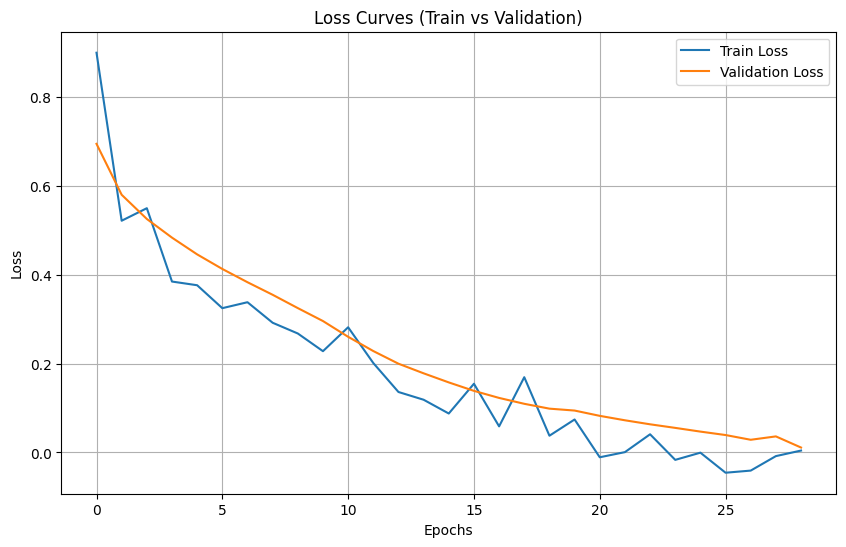

In [100]:
plot_loss(train_losses[1:], val_losses[1:])

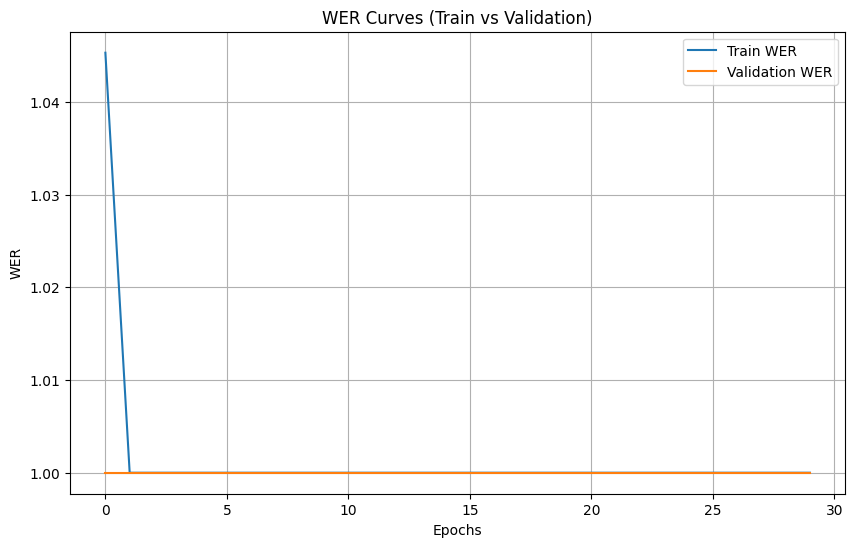

In [103]:
plot_wer(train_wers, val_wers)

CER Curves 

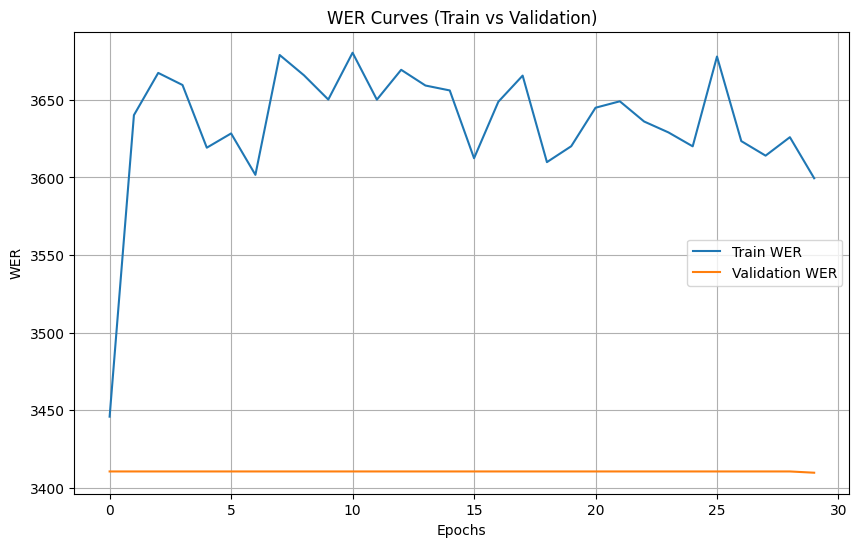

In [104]:
plot_wer(train_cers, val_cers)

In [ ]:
torch.save(best_model_wts, "best_model.pth")

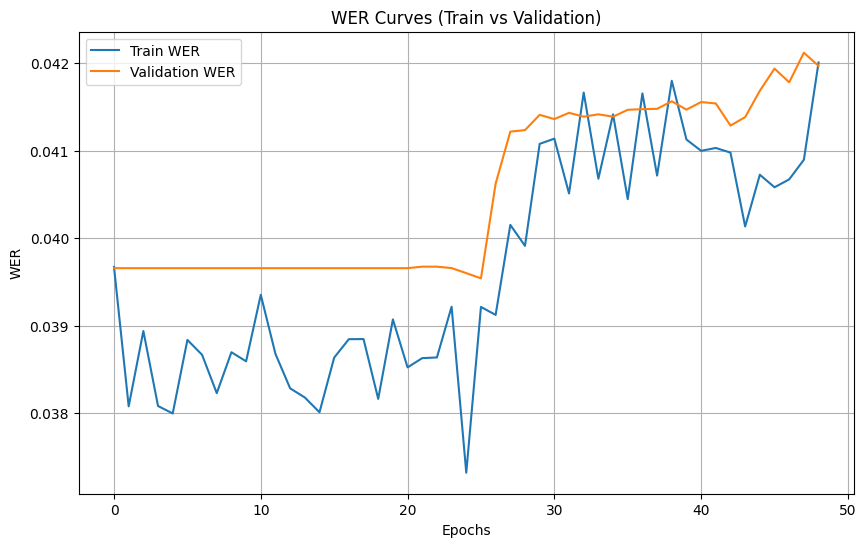

In [78]:
plot_wer(train_wer_scores, val_wer_scores)

In [ ]:
attention_weights = model.get_attention_weights(input_tensor)  # Input your tensor for which you want to plot
plot_attention_weights(attention_weights)

In [82]:
train_losses, val_losses, train_wer_scores, val_wer_scores = train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    vocab_dict=vocab_dict,
    num_epochs=30,
    device=device,
    patience=5
)

Epoch 1: Train Loss = 87.4830, Train WER = 1.0076, Train CER = 1.7139, Val Loss = 1.3696, Val WER = 1.0000, Val CER = 1.8091
Epoch 2: Train Loss = 0.7697, Train WER = 1.0000, Train CER = 1.6965, Val Loss = 0.6795, Val WER = 1.0000, Val CER = 1.8091
Epoch 3: Train Loss = 0.5354, Train WER = 1.0000, Train CER = 1.7842, Val Loss = 0.5599, Val WER = 1.0000, Val CER = 1.8091
Epoch 4: Train Loss = 0.3851, Train WER = 1.0000, Train CER = 1.6771, Val Loss = 0.5039, Val WER = 1.0000, Val CER = 1.8091
Epoch 5: Train Loss = 0.3977, Train WER = 1.0000, Train CER = 1.7682, Val Loss = 0.4615, Val WER = 1.0000, Val CER = 1.8091
Epoch 6: Train Loss = 0.4180, Train WER = 1.0000, Train CER = 1.8266, Val Loss = 0.4253, Val WER = 1.0000, Val CER = 1.8091
Epoch 7: Train Loss = 0.3144, Train WER = 1.0000, Train CER = 1.7138, Val Loss = 0.3921, Val WER = 1.0000, Val CER = 1.8091
Epoch 8: Train Loss = 0.3273, Train WER = 1.0000, Train CER = 1.7666, Val Loss = 0.3585, Val WER = 1.0000, Val CER = 1.8091
Epoch 9

ValueError: too many values to unpack (expected 4)

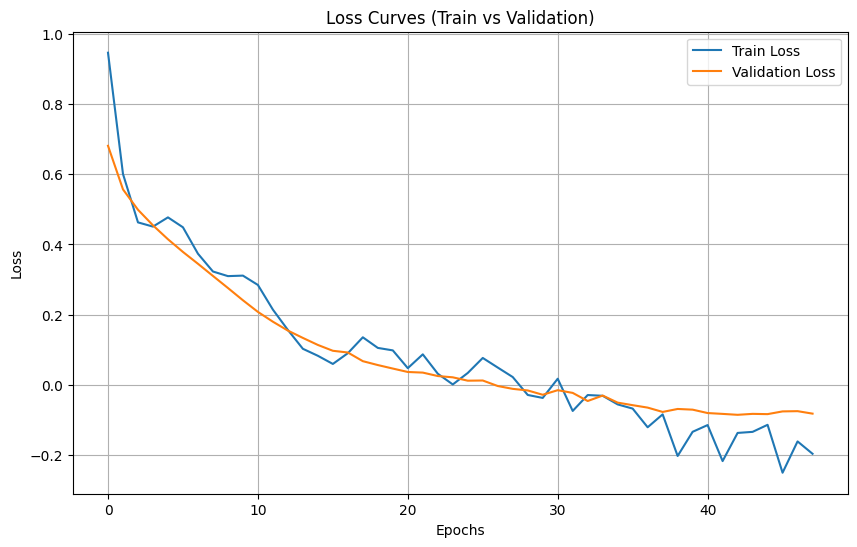

In [83]:
plot_loss(train_losses[1:], val_losses[1:])

### Evaluation

In [106]:
test_loss, test_wer, test_cer = evaluate(model, test_loader, criterion, device, vocab_dict)
print(f"Test Loss: {test_loss:.4f}, Test WER: {test_wer:.4f}, Test CER: {test_cer:.4f}")


Test Loss: 0.2089, Test WER: 1.0000, Test CER: 3279.1620


In [ ]:
plot_loss(train_losses[1:], val_losses[1:])

## Round 2

In [49]:
train_losses, val_losses, train_wers, val_wers, train_cers, val_cers = train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    vocab_dict=vocab_dict,
    num_epochs=30,
    device=device,
    patience=5
)

Epoch 1: Train Loss = 0.4232, Train WER = 0.9747, Train CER = 0.9954, Val Loss = 0.4969, Val WER = 0.9156, Val CER = 0.9951
Epoch 2: Train Loss = 0.3213, Train WER = 0.9573, Train CER = 0.9953, Val Loss = 0.4584, Val WER = 0.9156, Val CER = 0.9951
Epoch 3: Train Loss = 0.3603, Train WER = 0.9806, Train CER = 0.9953, Val Loss = 0.4237, Val WER = 0.9156, Val CER = 0.9951
Epoch 4: Train Loss = 0.4388, Train WER = 0.9694, Train CER = 0.9956, Val Loss = 0.3915, Val WER = 0.9156, Val CER = 0.9951
Epoch 5: Train Loss = 0.3433, Train WER = 0.9852, Train CER = 0.9954, Val Loss = 0.3602, Val WER = 0.9156, Val CER = 0.9951
Epoch 6: Train Loss = 0.2576, Train WER = 0.9631, Train CER = 0.9954, Val Loss = 0.3294, Val WER = 0.9156, Val CER = 0.9951
Epoch 7: Train Loss = 0.2339, Train WER = 0.9554, Train CER = 0.9953, Val Loss = 0.2955, Val WER = 0.9156, Val CER = 0.9951
Epoch 8: Train Loss = 0.1485, Train WER = 0.9500, Train CER = 0.9953, Val Loss = 0.2612, Val WER = 0.9156, Val CER = 0.9951
Epoch 9:

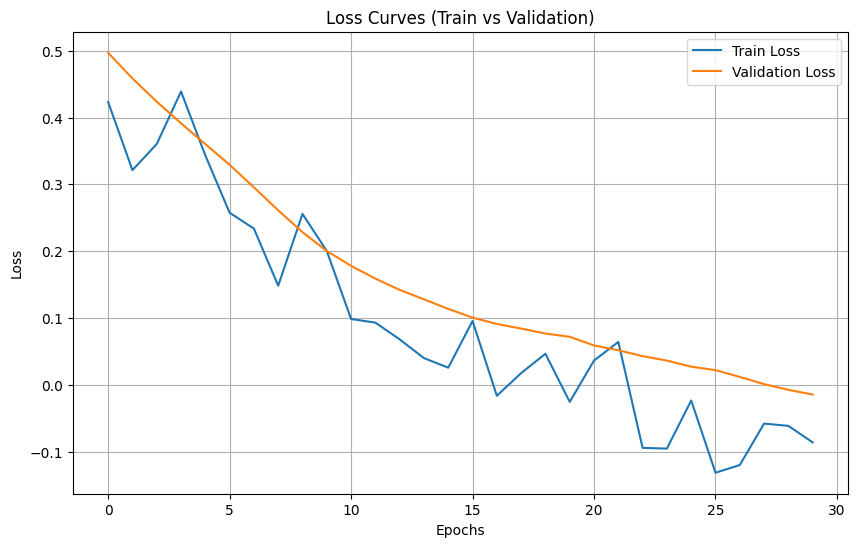

In [50]:
plot_loss(train_losses, val_losses)

In [55]:
test_loss, test_wer, test_cer = evaluate(model, test_loader, criterion, device, vocab_dict)
print(f"Test Loss: {test_loss:.4f}, Test WER: {test_wer:.4f}, Test CER: {test_cer:.4f}")

Test Loss: 0.1875, Test WER: 0.8818, Test CER: 0.9949


In [33]:
start_time = time.time()

train_losses, val_losses, train_wers, val_wers, train_cers, val_cers = train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    vocab_dict=vocab_dict,
    num_epochs=30,
    device=device,
    patience=5
)

end_time = time.time()

Epoch 1: Train Loss = 95.3839, Train WER = 0.9671, Train CER = 0.9945, Val Loss = 1.1787, Val WER = 0.9156, Val CER = 0.9951
Epoch 2: Train Loss = 0.7093, Train WER = 0.9751, Train CER = 0.9953, Val Loss = 0.6292, Val WER = 0.9156, Val CER = 0.9951
Epoch 3: Train Loss = 0.4495, Train WER = 0.9704, Train CER = 0.9953, Val Loss = 0.5341, Val WER = 0.9156, Val CER = 0.9951
Epoch 4: Train Loss = 0.3534, Train WER = 0.9885, Train CER = 0.9953, Val Loss = 0.4848, Val WER = 0.9156, Val CER = 0.9951
Epoch 5: Train Loss = 0.3950, Train WER = 0.9782, Train CER = 0.9954, Val Loss = 0.4468, Val WER = 0.9156, Val CER = 0.9951
Epoch 6: Train Loss = 0.3567, Train WER = 0.9800, Train CER = 0.9954, Val Loss = 0.4128, Val WER = 0.9156, Val CER = 0.9951
Epoch 7: Train Loss = 0.2706, Train WER = 0.9800, Train CER = 0.9954, Val Loss = 0.3830, Val WER = 0.9156, Val CER = 0.9951
Epoch 8: Train Loss = 0.3708, Train WER = 0.9907, Train CER = 0.9955, Val Loss = 0.3554, Val WER = 0.9156, Val CER = 0.9951
Epoch 9

NameError: name 'end' is not defined

In [34]:
print(f"Training Time: {end_time - start_time} seconds")

Training Time: 1834.7507047653198 seconds
